 我们分析的目标有
- 平均宽度是多少？（一般行动力是多少）
    如果成功分析，下一步可以是：
    - 逆向ab剪枝，在1h的训练下，能够获得多少棋局的minimax value？ 能够得到多少层的信息？保存到磁盘上可不可行？
    - 正向ab剪枝，预测在numba加速的前提下，能够分析多少层？
- 出现对称剪枝的情况多不多？

 - 可以把统计数据记到回合上面，然后最后分析 开局、中局、残局的信息

In [1]:
from experiment.评估函数.simulator import Simulator
from experiment.评估函数.greedy_ai import GreedyAI
import experiment.old_ai.AI as ai
from numba import njit

import src.project1.submit.AI as new_ai

import numpy as np
import random

# chessboard_size = 4  # 4赛罗游戏

chessboard_size = 8  # 正常黑白棋游戏
time_out = 5

def random_baseline(a, p):
    return random.random()  # 0-1随机权重

In [2]:
# breadth = [0 for i in range(65)] # 4到64回合可以用
breadth = np.zeros(65) # 4到64回合可以用
breadth_times = np.zeros(65)
def account_breadth(rounds, color, chessboard, agents):
    b = len(new_ai.actions(chessboard, color))
    breadth[rounds] += b
    breadth_times[rounds]+=1

In [3]:
from src.project1.experimental.minimax迭代加深机 import *
from numba.typed import Dict
from numba import types

# @njit
def alpha_beta_search_account(chessboard, current_color, a_b_nodes, remaining_depth=8, alphas=np.array([-np.inf, -np.inf])):
    """

    :param chessboard:
    :param current_color:
    :param remaining_depth: 0 表示 直接对节点估值，不合法。 1表示一层贪心。 根据时间资源和回合数，请合理分配搜索深度。目前知道10层全回合OK的
    :param alphas: 0:到目前为止，路径上发现的 color=-1这个agent 的最佳选择值
                  1:到目前为止，路径上发现的 color= 1这个agent 的最佳选择值
    :param hash_table:
    :return: 返回对于chessboard,color这个节点，它最大的选择值是多少，以及它选择了哪个子节点。
    """
    a_b_nodes[0] +=1
    alphas = alphas.copy()  # 防止修改上面的alphas
    if is_terminal(chessboard):
        utility = current_color * get_winner(chessboard)  # winner的颜色和我相等，就是1（颜色的平方性质）， 和我的颜色不等，就是-1.
        return min_max_normalized_value(-1, 1, utility), None  # 满足截断性。由于其他价值函数也归一化了，0和1就是最小值和最大值

    acts = typed.List(actions(chessboard, current_color))
    if len(acts) == 0:
        # 只能选择跳过这个action，value为对方的value
        value, move = alpha_beta_search_account(chessboard, -current_color, a_b_nodes, remaining_depth - 1, alphas)
        return -value, None  # 对手的值是和我反的。 我方没有action可以做。
    new_chessboards = typed.List([updated_chessboard(chessboard, current_color, a) for a in acts])  # 用最多10倍内存换一半时间（排序和实际操作共用结果）
    hash_table = Dict.empty(
        key_type=types.UniTuple(types.uint64, 2),
        value_type=types.float64  # 表示节点的价值。 如果哈希表有值，优先使用该值排序
    )  # 如果有LRU，可以把继承上一次的table
    insertion_sort(acts, new_chessboards, current_color, hash_table, 4)

    if remaining_depth <= 1:  # 比如要求搜索1层，就是直接对max节点的所有邻接节点排序返回最大的。
        return value_of_positions(new_chessboards[0], current_color), acts[0]  # 评价永远是根据我方的棋盘

    value, move = -np.inf, None  # 写在一起。每个节点都尝试让自己的价值最大化
    this_color_idx, other_color_idx = int((current_color + 1) // 2), int((-current_color + 1) // 2)
    for i, new_chessboard in enumerate(new_chessboards):
        action = acts[i]

        new_value, t = alpha_beta_search_account(new_chessboard, -current_color, a_b_nodes, remaining_depth - 1, alphas)
        new_value = -new_value

        if new_value > value:
            value, move = new_value, action

            alphas[this_color_idx] = max(alphas[this_color_idx], value)
        # 另一种颜色的某一个节点已经到达了c = -beta的水平，低于c的都不接受。
        # 而我这个节点，至少可以达到v的水平。
        # 在那个对手节点看来，我至多会选择-v， 如果它自己的c已经比我这个-v大了，
        # 他就不会考虑我，我被剪枝，随便返回一个我的值和选择。
        if -value <= alphas[other_color_idx]:
            return value, move
    return value, move

In [6]:
a_b_nodes = np.zeros(65)
a_b_nodes_times = np.zeros(65)

def account_a_b_nodes(rounds, color, chessboard, agents):
    global a_b_nodes, a_b_nodes_times
    a_b_node = np.zeros(1)
    alpha_beta_search_account(chessboard, color, a_b_node, 2)
    a_b_nodes[rounds] += a_b_node[0]
    a_b_nodes_times[rounds]+=1

In [7]:
def do_account_tenth():
    # accountants = [account_breadth]
    accountants = [account_a_b_nodes]
    for i in range(10):
        for i_color in [ai.COLOR_BLACK, ai.COLOR_WHITE]:
            agents = {i_color: GreedyAI(chessboard_size, i_color, random_baseline),
                      -i_color: GreedyAI(chessboard_size, -i_color, random_baseline)}
            simulator = Simulator(chessboard_size, time_out, agents)
            winner = simulator.quick_run(accountants, True)

In [9]:
do_account_tenth()

spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!
spin once!


In [10]:
avg_a_b_nodes = np.nan_to_num(a_b_nodes/a_b_nodes_times)
print(avg_a_b_nodes.max())
avg_a_b_nodes

14.55


C:\Users\YeCanming\AppData\Local\Temp\ipykernel_2784\10649458.py:1: RuntimeWarning: invalid value encountered in true_divide
  avg_a_b_nodes = np.nan_to_num(a_b_nodes/a_b_nodes_times)


array([ 0.        ,  0.        ,  0.        ,  0.        ,  5.        ,
        4.        ,  5.45      ,  5.775     ,  6.725     ,  6.85      ,
        7.35      ,  8.575     ,  8.825     ,  9.325     , 10.25      ,
       10.775     , 10.35      , 11.55      , 11.15      , 11.975     ,
       11.275     , 12.325     , 11.5       , 12.7       , 11.925     ,
       13.8       , 12.75      , 13.625     , 12.675     , 13.8       ,
       12.525     , 13.75      , 12.825     , 14.325     , 13.075     ,
       14.55      , 12.85      , 14.2       , 12.375     , 13.75      ,
       11.975     , 13.35      , 11.5       , 12.525     , 11.1       ,
       11.6       , 10.8       , 11.375     ,  9.625     , 10.        ,
        9.2       ,  9.15      ,  8.15      ,  8.25      ,  7.25      ,
        7.3       ,  5.875     ,  6.125     ,  4.90243902,  4.87804878,
        3.93023256,  3.6       ,  3.06382979,  2.        ,  0.        ])

In [10]:
print(breadth)
print(breadth_times)    # 第六十四回合永远terminal，所以nan

[  0.   0.   0.   0. 160. 120. 185. 202. 230. 243. 285. 298. 322. 325.
 359. 357. 364. 399. 389. 414. 440. 423. 461. 451. 456. 486. 461. 474.
 491. 479. 497. 469. 516. 490. 519. 495. 510. 469. 487. 463. 483. 445.
 464. 434. 430. 405. 420. 362. 380. 340. 339. 306. 300. 267. 278. 222.
 212. 183. 166. 139. 113.  89.  66.  40.   0.]
[ 0.  0.  0.  0. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40. 40. 41. 40. 40. 40. 42. 46. 57.  0.]


In [19]:
avg_breadths = np.nan_to_num(breadth/breadth_times)
print(avg_breadths)

[ 0.          0.          0.          0.          4.          3.
  4.625       5.05        5.75        6.075       7.125       7.45
  8.05        8.125       8.975       8.925       9.1         9.975
  9.725      10.35       11.         10.575      11.525      11.275
 11.4        12.15       11.525      11.85       12.275      11.975
 12.425      11.725      12.9        12.25       12.975      12.375
 12.75       11.725      12.175      11.575      12.075      11.125
 11.6        10.85       10.75       10.125      10.5         9.05
  9.5         8.5         8.475       7.65        7.5         6.675
  6.95        5.55        5.3         4.46341463  4.15        3.475
  2.825       2.11904762  1.43478261  0.70175439  0.        ]


C:\Users\YeCanming\AppData\Local\Temp\ipykernel_14172\2469600728.py:1: RuntimeWarning: invalid value encountered in true_divide
  avg_breadths = np.nan_to_num(breadth/breadth_times)


In [20]:
avg_breadths.mean()

8.093369219197761

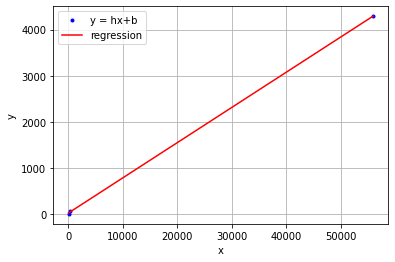

(0.07629278861048339, 21.33424487500785)

In [28]:
import numpy as np
import scipy as sp   ##在numpy基础上实现的部分算法库

import matplotlib.pyplot as plt  ##绘图库

from scipy.optimize import leastsq  ##引入最小二乘法算法

x = np.array([14.55, 296.35, 55950.05])
y = np.array([1, 65.4965, 4289.8110])
def linear_regression(x,y):
    N = len(x)
    sumx = sum(x)
    sumy = sum(y)
    sumx2 = sum(x**2)
    sumxy = sum(x*y)
    A = np.mat([[N,sumx],[sumx,sumx2]])
    b = np.array([sumy,sumxy])

    return np.linalg.solve(A,b)
b,k = linear_regression(x,y)

# reg = np.polyfit(x,y,deg=1) #输入训练样本  设置一元
# ry = np.polyval(reg,x)
ry = k*x+b
plt.plot(x,y,'b.',label='y = hx+b')
plt.plot(x,ry,'r',label='regression')
plt.legend(loc=0) #左上角显示label
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
# plt.loglog()
plt.savefig('linear.png')
plt.show()
k, b